In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import  f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from statistics import stdev
import warnings
warnings.filterwarnings('ignore')

# Seed value
seed_value = 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

2023-03-18 15:28:36.707881: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-18 15:28:36.886683: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-18 15:28:37.450015: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib:
2023-03-18 15:28:37.450300: W tensorflow/compiler/xla/stream_executor/platfor

2023-03-18 15:28:38.488983: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-18 15:28:38.489248: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-18 15:28:38.489380: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-18 15:28:38.489806: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19205 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


In [2]:
# Load .wav files
paths = []
labels = []
types = ['jazz' , 'country' , 'disco' , 'hiphop' , 'latin' , 'metal' , 'randb' , 'EDM']
for name in types:
    for dirname, _, filenames in os.walk('/home/PP/.test/subAudio/' + name):
        for filename in filenames:
            paths.append(os.path.join(dirname, filename))
            labels.append(name)

    
print(len(paths))
print(len(labels))

0
0


In [3]:
# make dataframe
df = pd.DataFrame()
df['sound'] = paths
df['label'] = labels
df.head()

,sound,label


In [4]:
df['label'].value_counts()

jazz       158
EDM        146
country    143
latin      129
hiphop     122
randb      113
disco      111
metal      104
Name: label, dtype: int64

In [5]:
# extract mfcc features of each 30 seconds long music sections , 75 is better than 100 and 40
n = 75
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=30, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n).T, axis=0)
    return mfcc

In [6]:
X_mfcc = df['sound'].apply(lambda x: extract_mfcc(x))

In [7]:
# for doing some preprocessing
X = [x for x in X_mfcc]
X = np.array(X)


from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])
y = y.toarray()

In [8]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout , Bidirectional
def create_bilstm_model():
    # Bi-LSTM model
    bilstm = Sequential([
        Bidirectional(LSTM(512, return_sequences=True, input_shape=(n,1))),
        Bidirectional(LSTM(512, return_sequences=True)),
        Bidirectional(LSTM(512)),
        Dropout(0.2),
        Dense(len(types), activation='softmax')
    ])
    bilstm.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return bilstm

In [9]:
def create_lstm_model():
    # LSTM model
    lstm = Sequential([
        LSTM(512, return_sequences=True, input_shape=(n,1)),
        LSTM(512, return_sequences=True),
        LSTM(512),
        Dropout(0.2),
        Dense(len(types), activation='softmax')
    ])

    lstm.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return lstm

In [10]:
def create_logistic_model():
    # Logistic Regression model
    Logistic_Regression = LogisticRegression(max_iter = 200 , random_state = 42)
    return Logistic_Regression

In [11]:
# some functions to compute different metrics and draw confusion matrix
def classification_task(model , features_train , y_train , features_test , y_test , predict):
  Train_Score = model.score(features_train, y_train)
  Test_Score = model.score(features_test, y_test)
  Precision_Score = precision_score(y_test,predict,average = 'macro')
  Recall_Score = recall_score(y_test,predict, average = 'macro')
  F1_Score = f1_score(y_test,predict, average = 'macro')
  accuracy = accuracy_score(y_test,predict)
  return np.array([Train_Score , Test_Score , Precision_Score , Recall_Score , F1_Score , accuracy])

def classification_task_NN(model , model_history , features_test , y_test , predict):
  results = model.evaluate(features_test, y_test)
  y_test_labels = [np.argmax(p) for p in y_test]
  Train_Score = model_history.history['accuracy'][-1]
  Test_Score = results[1]
  Precision_Score = precision_score(y_test_labels ,predict,average = 'macro')
  Recall_Score = recall_score(y_test_labels,predict, average = 'macro')
  F1_Score = f1_score(y_test_labels,predict, average = 'macro')
  accuracy = accuracy_score(y_test_labels,predict)
  return np.array([Train_Score , Test_Score , Precision_Score , Recall_Score , F1_Score , accuracy])

def Draw_confusion_matrix(ttl_cf_matrix , class_names , model_name):                                                                                          
  df_cm = pd.DataFrame(ttl_cf_matrix, class_names, class_names)
  sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
  plt.xlabel("prediction")
  plt.ylabel("ground truth")
  plt.savefig(f'confusion_matrix_{model_name}.png')

def Draw_Beautiful_dataframe(avg_info , model_name):
  perf_df = pd.DataFrame({'Train_Score':avg_info[0],
            "Test_Score":avg_info[1],
            "Precision_Score":avg_info[2],
            "Recall_Score":avg_info[3],
            "F1_Score":avg_info[4],
            "accuracy":avg_info[5]}, index=[model_name])
  return perf_df


In [12]:
# a function to transform the input shape of data to fit logistic regression , 
# since logistic regression only take data with n_dim <= 2
# But LSTM layers need one more dimension to represent time 
def prepare_lstm_like_data(X , y):
    X_ = np.expand_dims(X , -1)
    return X_ , y

# a function to transform labels into form of label encoding to feed in sklearn logistic regression
def prepare_logistic_data(X , y):
    y_ = np.array([np.argmax(p) for p in y])
    return X , y_
    
# a function to run kfold validation on different model    
def Run_k_fold(n , X , y , model_name):
    # use stratified kfold to avoid data imbalance
    kf = StratifiedKFold(n_splits = n , shuffle = True , random_state = 42)
    X_final = None
    y_final = None
    if model_name != 'Logistic' : 
        X_final , y_final = prepare_lstm_like_data(X , y)
    else:
        X_final , y_final = prepare_logistic_data(X , y)
    y_fold_original_for_kfold = [np.argmax(p) for p in y]
    folds = []
    ttl_cf_matrix = None
    for i, (train_index, test_index) in enumerate(kf.split(X , y_fold_original_for_kfold)):
        X_fold_train = np.array([X_final[id] for id in train_index])
        X_fold_test = np.array([X_final[id] for id in test_index])
        y_fold_train = np.array([y_final[id] for id in train_index])
        y_fold_test = np.array([y_final[id] for id in test_index])
        if model_name == 'bilstm':
            bilstm = create_bilstm_model()
            history_bilstm = bilstm.fit(X_fold_train , y_fold_train , epochs=200, batch_size=64)
            predictions = bilstm.predict(X_fold_test)
            predictions = [np.argmax(p) for p in predictions]
            info = classification_task_NN(bilstm , history_bilstm , X_fold_test , y_fold_test , predictions)
            y_fold_test_for_cf = [np.argmax(p) for p in y_fold_test]
            cf_matrix = confusion_matrix(y_fold_test_for_cf , predictions)
        elif model_name == 'lstm':
            lstm = create_lstm_model()
            history_lstm = lstm.fit(X_fold_train , y_fold_train , epochs=200, batch_size=64)
            predictions = lstm.predict(X_fold_test)
            predictions = [np.argmax(p) for p in predictions]
            info = classification_task_NN(lstm , history_lstm , X_fold_test , y_fold_test , predictions)
            y_fold_test_for_cf = [np.argmax(p) for p in y_fold_test]
            cf_matrix = confusion_matrix(y_fold_test_for_cf , predictions)
        else:
            Logistic_Regression = create_logistic_model()
            Logistic_Regression.fit(X_fold_train , y_fold_train)
            pred_rand = Logistic_Regression.predict(X_fold_test)
            info = classification_task(Logistic_Regression , X_fold_train , y_fold_train , X_fold_test , y_fold_test , pred_rand)
            cf_matrix = confusion_matrix(y_fold_test , pred_rand)
        folds.append(info)
        if i == 0:
            ttl_cf_matrix = cf_matrix
        else:
            ttl_cf_matrix += cf_matrix # all fold's of confusion matrix is added together
    folds = np.array(folds)
    f1s = [fold[-2] for fold in folds]
    avg_info = np.mean(folds , axis=0) # average all 5 folds for all kinds of metrics , and send these averaged value to function to draw dataframe
    perf_df = Draw_Beautiful_dataframe(avg_info , model_name)
    return stdev(f1s) , perf_df , ttl_cf_matrix

2023-03-12 04:33:32.232811: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-12 04:33:32.233060: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-12 04:33:32.233114: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-12 04:33:32.233451: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-12 04:33:32.233506: I tensorflow/compiler/xla/stream_executo

Epoch 1/200


2023-03-12 04:33:39.869339: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8500
2023-03-12 04:33:40.082669: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-12 04:33:40.097264: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f307c1ef1a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-12 04:33:40.097350: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-03-12 04:33:40.128122: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-12 04:33:40.339541: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of 

13/13 [==============================] - 9s 32ms/step - loss: 2.1527 - accuracy: 0.2207
Epoch 2/200
13/13 [==============================] - 0s 31ms/step - loss: 1.7166 - accuracy: 0.3232
Epoch 3/200
13/13 [==============================] - 0s 30ms/step - loss: 1.6435 - accuracy: 0.3878
Epoch 4/200
13/13 [==============================] - 0s 31ms/step - loss: 1.4442 - accuracy: 0.4671
Epoch 5/200
13/13 [==============================] - 0s 31ms/step - loss: 1.3530 - accuracy: 0.5073
Epoch 6/200
13/13 [==============================] - 0s 31ms/step - loss: 1.2194 - accuracy: 0.5378
Epoch 7/200
13/13 [==============================] - 0s 31ms/step - loss: 1.1839 - accuracy: 0.5671
Epoch 8/200
13/13 [==============================] - 0s 31ms/step - loss: 1.0340 - accuracy: 0.6305
Epoch 9/200
13/13 [==============================] - 0s 31ms/step - loss: 1.0474 - accuracy: 0.6110
Epoch 10/200
13/13 [==============================] - 0s 31ms/step - loss: 0.9077 - accuracy: 0.6720
Epoch 11/20

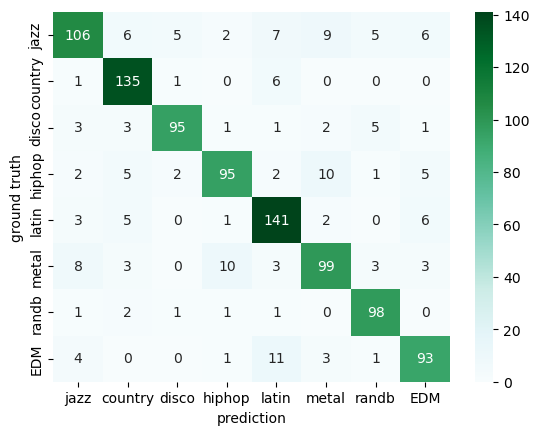

In [13]:
var_bilstm , metrics , matrix = Run_k_fold(5 , X , y , 'bilstm')
Draw_confusion_matrix(matrix , types , 'bilstm')

In [14]:
metrics

,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
bilstm,0.993421,0.840161,0.847507,0.841494,0.839708,0.840161


Epoch 1/200
13/13 [==============================] - 3s 14ms/step - loss: 2.0853 - accuracy: 0.1366
Epoch 2/200
13/13 [==============================] - 0s 14ms/step - loss: 2.0821 - accuracy: 0.1622
Epoch 3/200
13/13 [==============================] - 0s 14ms/step - loss: 2.0784 - accuracy: 0.1927
Epoch 4/200
13/13 [==============================] - 0s 14ms/step - loss: 2.1058 - accuracy: 0.1915
Epoch 5/200
13/13 [==============================] - 0s 14ms/step - loss: 2.0394 - accuracy: 0.1963
Epoch 6/200
13/13 [==============================] - 0s 14ms/step - loss: 2.0327 - accuracy: 0.1963
Epoch 7/200
13/13 [==============================] - 0s 14ms/step - loss: 1.9877 - accuracy: 0.2220
Epoch 8/200
13/13 [==============================] - 0s 14ms/step - loss: 1.9535 - accuracy: 0.2280
Epoch 9/200
13/13 [==============================] - 0s 14ms/step - loss: 1.8982 - accuracy: 0.2707
Epoch 10/200
13/13 [==============================] - 0s 14ms/step - loss: 1.9141 - accuracy: 0.2659

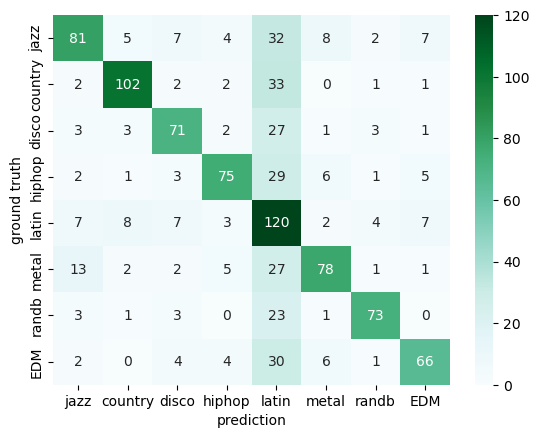

In [15]:
var_lstm , metrics , matrix = Run_k_fold(5 , X , y , 'lstm')
Draw_confusion_matrix(matrix , types , 'lstm')

In [16]:
metrics

,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
lstm,0.826308,0.649003,0.627093,0.647264,0.626627,0.649003


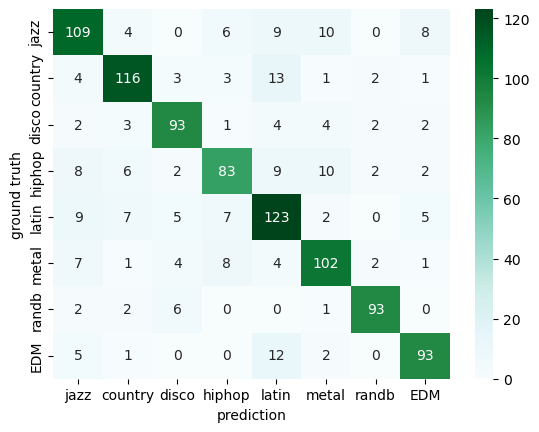

In [17]:
var_logistic , metrics , matrix = Run_k_fold(5 , X , y , 'Logistic')
Draw_confusion_matrix(matrix , types , 'Logistic')

In [18]:
metrics

,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
Logistic,0.915695,0.791414,0.806525,0.795084,0.796514,0.791414


In [19]:
print(f'Variance of Bi-LSTM : {var_bilstm}  ; Variance of LSTM : {var_lstm} ; Variance of Logistic Regression : {var_logistic}')

Variance of Bi-LSTM : 0.02299459151457381  ; Variance of LSTM : 0.33290107355431103 ; Variance of Logistic Regression : 0.037707047540477844
